In [9]:
import uproot
import os
import mplhep as hep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import vector

from importer import nanoaod_to_dataframe, compare_cells, get_z_m_pt, calculate_dr, apply_genmatching, get_closest_muon_data


In [2]:


data_path = "../data/2022G-nanoaod/2022G-data.root"
emb_path = "../data/2022G-nanoaod/2022G-emb.root"

output_path = "./data/converted"
dr_plot_path = "./output/dr_plots"

quantities = [
    {"key":"PuppiMET_pt",       "target":"PuppiMET_pt",     "expand":False},
    {"key":"PuppiMET_phi",      "target":"PuppiMET_phi",    "expand":False},
    {"key":"PuppiMET_sumEt",    "target":"PuppiMET_sumEt",  "expand":False},
    {"key":"Muon_phi",          "target":"phi",             "expand":True},
    {"key":"Muon_pt",           "target":"pt",              "expand":True},
    {"key":"Muon_eta",          "target":"eta",             "expand":True},
    {"key":"Muon_mass",         "target":"m",               "expand":True},
    {"key":"Jet_phi",           "target":"Jet_phi",         "expand":False},
    {"key":"Jet_pt",            "target":"Jet_pt",          "expand":False},
    {"key":"Jet_eta",           "target":"Jet_eta",         "expand":False},
    {"key":"Jet_mass",          "target":"Jet_mass",        "expand":False},
    {"key":"run",               "target":"run",             "expand":False},
    {"key":"luminosityBlock",   "target":"lumi",            "expand":False},
    {"key":"event",             "target":"event",           "expand":False}
]

print("Loading data")


data_df = nanoaod_to_dataframe(data_path=data_path, quantities=quantities)
emb_df = nanoaod_to_dataframe(data_path=emb_path, quantities=quantities)

print("Data loaded")



Loading data
Data loaded


In [5]:

data_df = data_df.sort_values(by=["run", "lumi", "event"], ignore_index=True)
emb_df = emb_df.sort_values(by=["run", "lumi", "event"], ignore_index=True)

compare_cells(data_df["event"].values, emb_df["event"].values)
compare_cells(data_df["lumi"].values, emb_df["lumi"].values)
compare_cells(data_df["run"].values, emb_df["run"].values)

print("Data ok")



Data ok


In [ ]:
def get_z_m_pt(df):
    #finds for each event the muon pair that fits best to the z boson mass. returns arrays with the mass and pt of the best fitting pair
    m_z = 91.1880
    m_vis = np.full(len(df), np.nan)
    pt_vis = np.full(len(df), np.nan)
    n_muon = get_nmuon(df, "eta_")

    for n_event in range(len(df)):
        row = df.iloc[n_event]
        best_m_vis = -1.
        best_pt_vis = -1.
        for n1 in range(1, n_muon+1):
            for n2 in range(1, n_muon+1):
                m_temp = generate_m_vis(row[f"pt_{n1}"], row[f"eta_{n1}"], row[f"phi_{n1}"], row[f"m_{n1}"], row[f"pt_{n2}"], row[f"eta_{n2}"], row[f"phi_{n2}"], row[f"m_{n2}"])
                pt_temp = generate_pt_vis(row[f"pt_{n1}"], row[f"eta_{n1}"], row[f"phi_{n1}"], row[f"m_{n1}"], row[f"pt_{n2}"], row[f"eta_{n2}"], row[f"phi_{n2}"], row[f"m_{n2}"])

                if abs(m_z-m_temp) < abs(m_z-best_m_vis):
                    best_m_vis = m_temp
                    best_pt_vis = pt_temp

        if best_m_vis != -1.:
            m_vis[n_event] = best_m_vis
        if best_pt_vis != -1.:
            pt_vis[n_event] = best_pt_vis
    
    return m_vis, pt_vis


def get_nmuon(df, column):
    #returns the number of muons that is available in the dataset (the highest index that can be found behind the column base name)
    max_n = 0
    for col in df.columns:
        if col.startswith(column):
            n = col.rsplit("_", 1)[1]
            n = int(n)
            if n > max_n:
                max_n = n
    return max_n

def generate_m_vis(pt_1, eta_1, phi_1, m_1, pt_2, eta_2, phi_2, m_2):
    #calculates m_vis of a muon pair
    p4_1 = vector.MomentumObject4D(pt=pt_1, phi=phi_1, eta=eta_1, mass=m_1)
    p4_2 = vector.MomentumObject4D(pt=pt_2, phi=phi_2, eta=eta_2, mass=m_2)
    p4_vis = p4_1 + p4_2
    m_vis = p4_vis.m

    return m_vis

def generate_pt_vis(pt_1, eta_1, phi_1, m_1, pt_2, eta_2, phi_2, m_2):
    #calculates pt_vis of a muon pair
    p4_1 = vector.MomentumObject4D(pt=pt_1, phi=phi_1, eta=eta_1, mass=m_1)
    p4_2 = vector.MomentumObject4D(pt=pt_2, phi=phi_2, eta=eta_2, mass=m_2)
    p4_vis = p4_1 + p4_2
    pt_vis = p4_vis.pt

    return pt_vis



In [14]:
data_df["m_vis"], data_df["pt_vis"] = get_z_m_pt(data_df)
emb_df["m_vis"], emb_df["pt_vis"] = get_z_m_pt(emb_df)

print("Added m_vis and pt_vis")



(24951,)


TypeError: 'numpy.float64' object does not support item assignment

In [10]:
dr = calculate_dr(data_df, emb_df, 2, 5, filter=False)

(array([2.2805e+04, 4.1000e+01, 8.8000e+01, 1.1400e+02, 5.4400e+02,
        1.0290e+03, 2.3800e+02, 5.0000e+01, 1.8000e+01, 2.4000e+01]),
 array([0.        , 0.6282959 , 1.2565918 , 1.8848877 , 2.51318359,
        3.14147949, 3.76977539, 4.39807129, 5.02636719, 5.65466309,
        6.28295898]),
 <BarContainer object of 10 artists>)

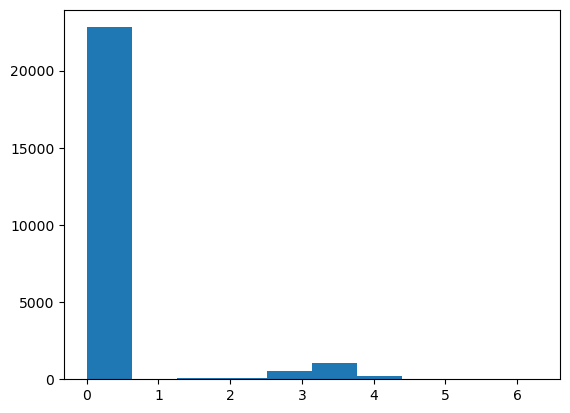

In [12]:
plt.hist(dr[:,0,0])

In [ ]:

mu_index, mu_dr = get_closest_muon_data(dr)

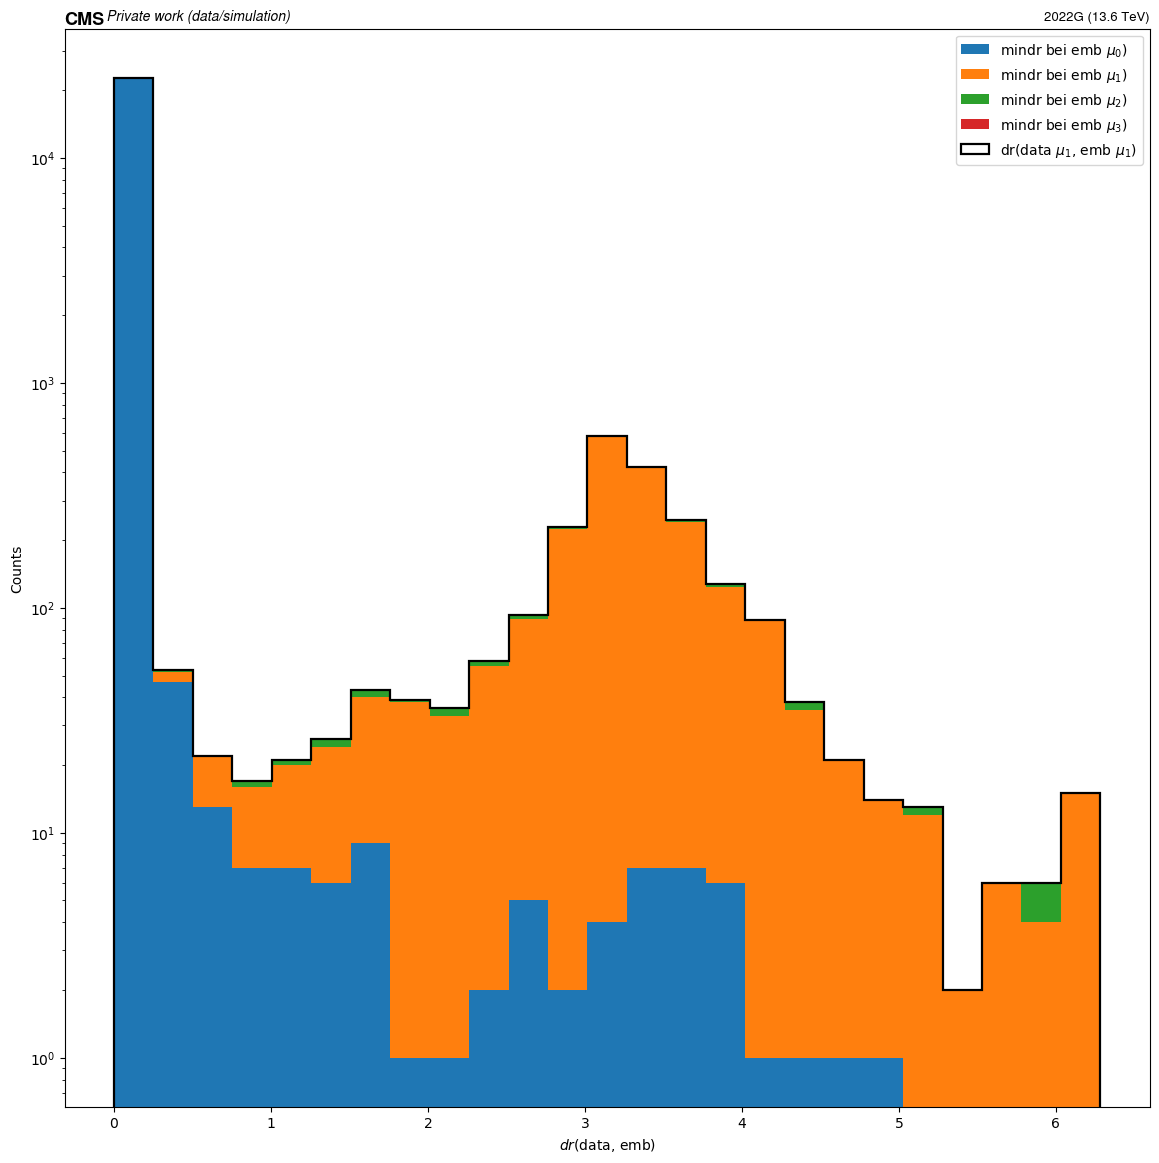

In [13]:

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(14)
fig.set_figwidth(14)

hist2, edges, _ = ax.hist([dr[mu_index==num, 0,0] for num in np.unique(mu_index)], bins=25, label=[f"mindr bei emb $µ_{num} $)" for num in np.unique(mu_index)], stacked=True)
hist, _, _ = ax.hist(dr[:,0,0], bins=edges, label=f"dr(data $µ_1$, emb $µ_{1}$)", histtype="step", color="black", linewidth=1.6)

hep.cms.label("Private work (data/simulation)", data=True, loc=0, year="2022G", com=13.6)#, lumi=59.8
ax.set_ylabel("Counts")
ax.set_xlabel(r"$dr(\text{data, emb})$")
ax.set_yscale("log")

plt.legend()
plt.show()

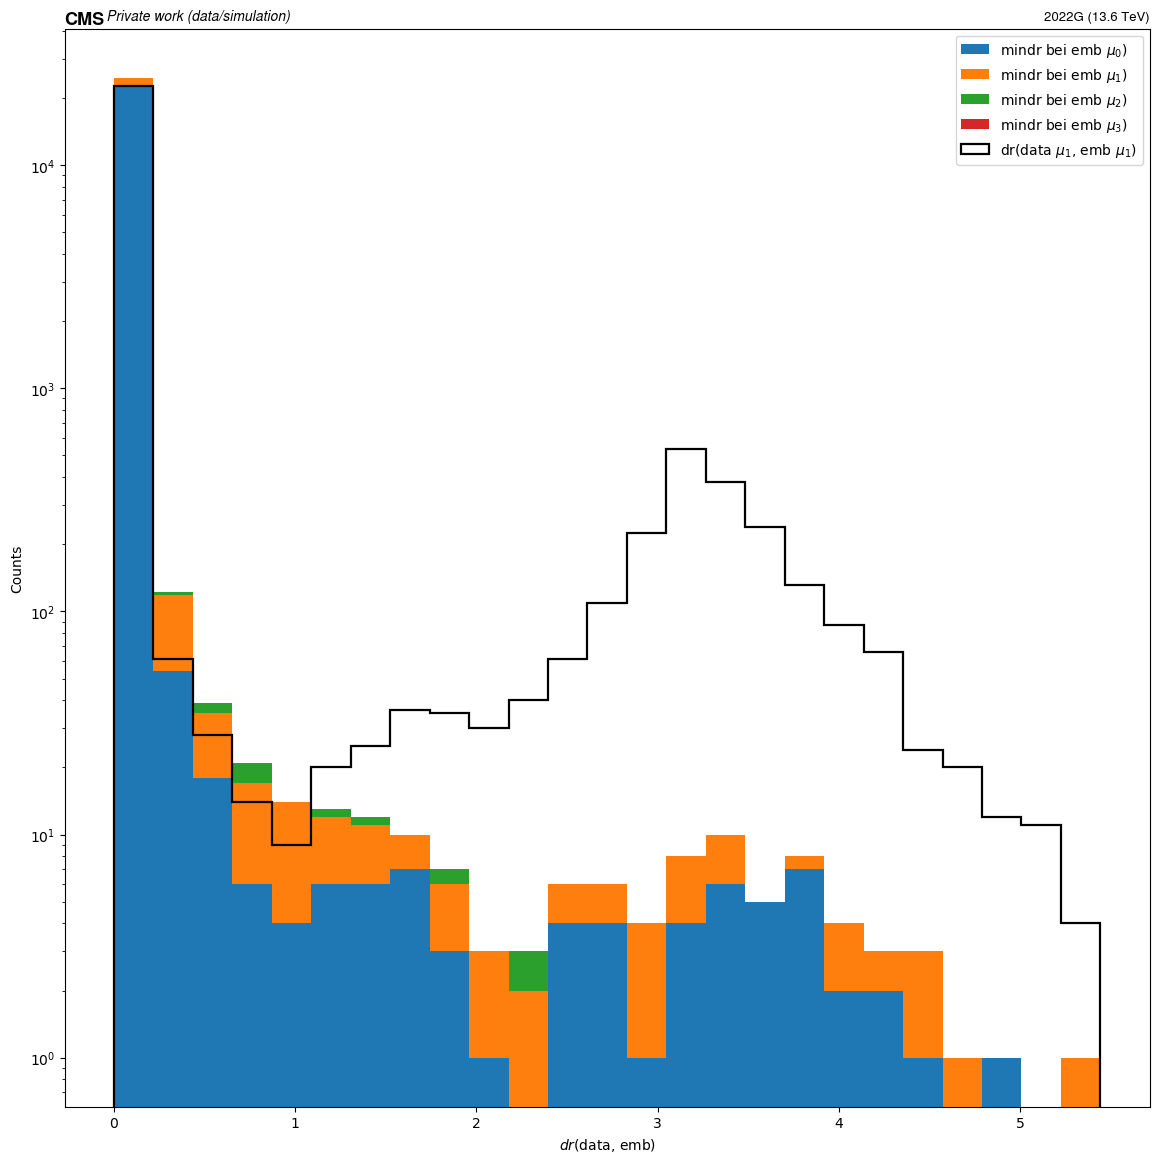

In [14]:


fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(14)
fig.set_figwidth(14)

hist2, edges, _ = ax.hist([mu_dr[mu_index==num] for num in np.unique(mu_index)], bins=25, label=[f"mindr bei emb $µ_{num} $)" for num in np.unique(mu_index)], stacked=True)
hist, _, _ = ax.hist(dr[:,0,0], bins=edges, label=f"dr(data $µ_1$, emb $µ_{1}$)", histtype="step", color="black", linewidth=1.6)

hep.cms.label("Private work (data/simulation)", data=True, loc=0, year="2022G", com=13.6)#, lumi=59.8
ax.set_ylabel("Counts")
ax.set_xlabel(r"$dr(\text{data, emb})$")
ax.set_yscale("log")

plt.legend()
plt.show()


